Задача: Для каждого клиента из тестового множества предсказать вероятность, что он примет кокретнвый сценарий

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics, cross_validation
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from utils import Dummyfier, prepare, evaluate_clf, uplift, print_metrics #print_metrics_2

%matplotlib inline

In [3]:
train = pd.read_csv('./train_data/train_dataset.csv', 
                    sep='>', na_values='<null>', 
                    parse_dates=['START_DATE', 'LAST_CARD_STATUS_DT', 'LAST_CONTR_STATUS_DT', 'BIRTH_DATE'])
print('Dataset size: ', train.shape)
train.head(2)

Dataset size:  (114720, 215)


,CONTRACT_REF,CLIENT_ID,CONTROL_GROUP_FLG,START_DATE,TARGET,11_AddrCity2,11_AddrCountry,12_AddrCity2,12_AddrCountry,13_AddrCity2,...,TXN_TP_POS_N_180,TXN_TP_POS_N_31,TXN_TP_POS_N_90,TXN_TP_POS_SUM_180,TXN_TP_POS_SUM_31,TXN_TP_POS_SUM_90,TXN_TP_Purposeful credit_MAX_180,TXN_TP_Purposeful credit_MEAN_180,TXN_TP_Purposeful credit_N_180,TXN_TP_Purposeful credit_SUM_180
0,273-P-99431598,105098373,N,2017-01-23,1,ГОРЯЧИЙКЛЮЧ,RU,ГОРЯЧИЙКЛЮЧ,RU,КАМЫШИН,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,274-P-23967129,101763714,N,2017-04-08,1,МУРМАНСК,RU,МУРМАНСК,RU,АХТУБИНСК,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
#train['START_DATE'].value_counts() #sort_values()

In [3]:
test = pd.read_csv('./test_data/test_dataset.csv', 
                   sep='>', na_values='<null>', 
                   parse_dates=['LAST_CARD_STATUS_DT', 'LAST_CONTR_STATUS_DT', 'BIRTH_DATE', 'START_DATE'])
print('Dataset size: ', test.shape)
#test = test.set_index(['CONTRACT_REF', 'CLIENT_ID'])
test.head(2)

Dataset size:  (92691, 212)


,11_AddrCity2,11_AddrCountry,12_AddrCity2,12_AddrCountry,13_AddrCity2,13_AddrCountry,BAL,BANK,BIRTH_DATE,CARD_CONTR_COUNT_0,...,TXN_TP_POS_N_180,TXN_TP_POS_N_31,TXN_TP_POS_N_90,TXN_TP_POS_SUM_180,TXN_TP_POS_SUM_31,TXN_TP_POS_SUM_90,TXN_TP_Purposeful credit_MAX_180,TXN_TP_Purposeful credit_MEAN_180,TXN_TP_Purposeful credit_N_180,TXN_TP_Purposeful credit_SUM_180
0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,BBKK,1986-12-29,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
1,NaN,NaN,NaN,NaN,NaN,NaN,0.0,BBKK,1968-03-11,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0


Так как предсказания будем строить только на множестве людей, которым какой-либо сценарий был предложен,
то сначала удаляем из данных контрольную группу и уже потом преобразуем данные:

In [5]:
train['CONTROL_GROUP_FLG'].value_counts(normalize=False)

N    97447
Y    17273
Name: CONTROL_GROUP_FLG, dtype: int64

In [6]:
train = train[train['CONTROL_GROUP_FLG']=='N']
train.drop(['CONTROL_GROUP_FLG'], axis=1, inplace=True)
train.shape

(97447, 214)

In [145]:
dummy = [u'CL_FAM_ST', u'CL_OFF_POS', u'CL_OWN_TYPE', u'LAST_CARD_STATUS', 'CL_ESTATE_TYPE', 
         'CL_INDUSTR', 'CL_SOC_ST', 'ZODIAC']

d = Dummyfier(dummy, drop_old=True)

Xy_train = prepare(train)
Xy_train = d.fit_transform(Xy_train)

In [50]:
# 'LAST_CARD_STATUS_TIME' / 'LAST_CONTR_STATUS_TIME',
#set(Xy_train.columns) - set(train.columns)

In [51]:
# Why cols have dissapear? 
#  'LAST_CARD_STATUS_DT' / 'LAST_CONTR_STATUS_DT',
#set(train.columns) - set(Xy_train.columns)

In [8]:
# WHY CHANGED ? Because of CGF == 1- ?
#Xy_train['SCENARIO_NAME_UNI'].value_counts()

In [146]:
# map scenarious and 
# remove too rare:
scenario_mapper = {'Sc_1':'UVEL_1', 'Sc_2':'UVEL_2','Sc_3':'UVEL_3','Sc_4':'UVEL_4','Sc_5':'UVEL_5','Sc_6':'UVEL_6'}

In [147]:
# simple example: 
a = pd.Series(['POS_1', 'Sc_1', 'UVEL_1', 'UVEL_2', 'Sc_2'])
b = a.map(scenario_mapper)
b[~b.notnull().values] = a[~b.notnull().values]
b

0     POS_1
1    UVEL_1
2    UVEL_1
3    UVEL_2
4    UVEL_2
dtype: object

In [148]:
# MAP SC_i  = UVEL_i  for i in 1:5
# This scenarious are same
Xy_train['SCENARIO_NAME'] = Xy_train['SCENARIO_NAME_UNI'].map(scenario_mapper)
unchanged_index = Xy_train['SCENARIO_NAME'].notnull().values
Xy_train['SCENARIO_NAME'][~ unchanged_index] = Xy_train['SCENARIO_NAME_UNI'][~ unchanged_index]

C:\Users\Liksakov\AppData\Local\Continuum\anaconda3_2\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [149]:
# To check:
#Xy_train[['SCENARIO_NAME', 'SCENARIO_NAME_UNI']]

In [150]:
#Xy_train['SCENARIO_NAME'].value_counts()
#Only ATM_1   scenario is rare, remove it:
Xy_train.drop(['SCENARIO_NAME_UNI'], axis=1,inplace=True)
Xy_train = Xy_train[~np.array(Xy_train['SCENARIO_NAME']=='ATM_1')]

In [151]:
Xy_train.shape

(97446, 144)

Объектами в задаче будут являться id = (CLIENT_ID, START_DATE, SCENARIO_NAME).
Таким образом для каждого клиента и сценария будут предсказаны вероятность выполнения целевого действия.
Полученная задача - обычная бинарная классификация.

 В качестве признаков будут использованы как признаки по клиенту, так и некоторые признаки, характеризующие сценарий.
Данный подход часто используется и отличается от подхода с построением мультиклассовой классификации на более простых объектах. (просто клиенты).

In [152]:
# ADD SCENARIO FEATURES DATA:
scen_data = pd.read_csv('./train_data/scenrios_descr.csv', sep=';', decimal=',')
#scen_data

In [153]:
# remove bad ( few y=1) scenarious
# remove some features
scen_to_leave = ['UVEL_2', 'ATM_2', 'ATM_1', 'UVEL_6']
scen_data = scen_data[~scen_data['SCENARIO_NAME'].isin(scen_to_leave)]
scen_data.drop(['MIN_CASHBACK','MAX_CASHBACK'],axis=1, inplace=True)

In [210]:
#scen_data

Подтягиваем признаки по сценариям.

In [154]:
# BE CAREFUL: inner join!
Xy_train = Xy_train.merge(scen_data, how='inner', on='SCENARIO_NAME')

In [155]:
# CHECK NA:
print( np.array(Xy_train['CL_AMT_ZP'].isna()*1).max() )
print( np.array(Xy_train['CL_AMT_DOP'].isna()*1).max() )

1
0


In [156]:
# Get list names of columns with at least one value is NAN
na_cols_train = Xy_train.isna().any()
na_cols_train = na_cols_train[na_cols_train==True].index.tolist()
# Fill nan with mean value
# not good idea for binaries
Xy_train = Xy_train.fillna(value=Xy_train[na_cols_train].mean())

In [157]:
# Check no NaN values:
np.sum(np.array(Xy_train.isna())*1.0)

0.0

In [158]:
Xy_train[['CLIENT_ID', 'SCENARIO_NAME', 'TARGET']].groupby(['SCENARIO_NAME'])\
    .agg({
        'TARGET': 'mean',
        'CLIENT_ID': 'count'
    })\
    .sort_values('TARGET', ascending=False)
    
# REMOVE LAST 3 SCENARIOUS

,TARGET,CLIENT_ID
SCENARIO_NAME,,
POS_1,0.152908,2459
UVEL_3,0.099837,2454
UVEL_1,0.073150,3527
POS_3,0.068110,18984
POS_2,0.050446,10863
UVEL_4,0.040017,26189
UVEL_5,0.039964,5555
ATM_3,0.030435,12847


In [159]:
# Split data: Train and test
Xy_tr, Xy_ts = train_test_split(Xy_train, 
                                test_size=0.2,
                                random_state=43,
                                shuffle=True,
                                stratify=Xy_train['SCENARIO_NAME']) #Xy_train['TARGET']) 

In [27]:
# f = 'CLIENT_ID'
# print(np.sum(Xy_train[f].isna()))
# print(np.sum(Xy_tr[f].isna()))

In [28]:
#Xy_tr.iloc[1:10,10:30]

In [29]:
#Xy_train['FL_DOC_PROFIT'].value_counts(normalize=True)

In [160]:
print('Check size:')
print(Xy_tr.shape[0]/Xy_train.shape[0])
print(Xy_ts.shape[0]/Xy_train.shape[0])
print('\nCheck  split stratification by taget:')
print(Xy_tr['TARGET'].value_counts(normalize=True)[1])
print(Xy_ts['TARGET'].value_counts(normalize=True)[1])
print('Check split stratification by SCENARIO:')
a1 = Xy_tr['SCENARIO_NAME'].value_counts(normalize=True)
a2 = Xy_ts['SCENARIO_NAME'].value_counts(normalize=True)
c = pd.concat([a1,a2],axis=1).reset_index()
c
#del(a1,a2, c)

Check size:
0.7999951736287072
0.20000482637129274

Check  split stratification by taget:
0.05280383698832614
0.05308880308880309
Check split stratification by SCENARIO:


,index,SCENARIO_NAME,SCENARIO_NAME
0,UVEL_4,0.315993,0.315999
1,POS_3,0.229058,0.229066
2,ATM_3,0.155018,0.154983
3,POS_2,0.131067,0.131093
4,UVEL_5,0.067027,0.067025
5,UVEL_1,0.042563,0.042531
6,POS_1,0.029667,0.029681
7,UVEL_3,0.029607,0.029621


In [126]:
# y_tr = Xy_tr['TARGET'].values
# y_ts = Xy_ts['TARGET'].values

# identity = ['CONTRACT_REF', 'CLIENT_ID', 'SCENARIO_NAME', 'START_DATE']

# # save just ids
# ids_tr = Xy_tr[['CONTRACT_REF', 'CLIENT_ID', 'SCENARIO_NAME']]
# ids_ts = Xy_ts[['CONTRACT_REF', 'CLIENT_ID', 'SCENARIO_NAME']]

# X_tr = Xy_tr.drop(['TARGET'] + identity, axis=1)
# X_ts = Xy_ts.drop(['TARGET'] + identity, axis=1)

In [161]:
y_tr = Xy_tr['TARGET'].values
y_ts = Xy_ts['TARGET'].values

identity = ['CONTRACT_REF', 'CLIENT_ID', 'SCENARIO_NAME', 'START_DATE', 'TARGET']

X_tr = Xy_tr.set_index(identity)
X_ts = Xy_ts.set_index(identity)

# X_tr = Xy_tr.drop(['TARGET'], axis=1)
# X_ts = Xy_ts.drop(['TARGET'], axis=1)

In [162]:
#X_tr.head(2)

In [229]:
#X_train.iloc[:,130:160]

In [163]:
# Use scaling:
scaler = StandardScaler()

In [164]:
# DO NOT USE : USE STEPS PIPLINES
X_tr_sc = pd.DataFrame(
    scaler.fit_transform(X_tr),
    columns=X_tr.columns,
    index=X_tr.index)

X_ts_sc = pd.DataFrame(
    scaler.transform(X_ts),
    columns=X_ts.columns,
    index=X_ts.index)

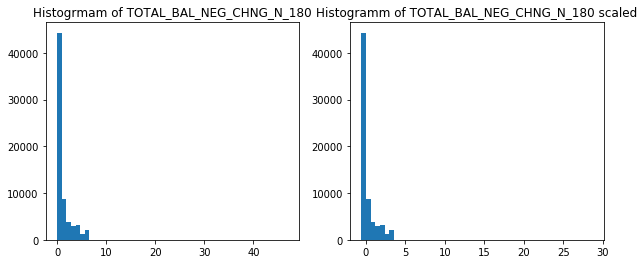

In [165]:
# Check distribution after scaling:
fig, axes = plt.subplots(1,2, figsize=(10,4))
feat_name = 'TOTAL_BAL_NEG_CHNG_N_180'

hists = [ feat_name, feat_name + ' scaled']

axes[0].hist(X_tr[feat_name], bins=50);
axes[0].title.set_text('Histogrmam of ' + hists[0]);

axes[1].hist(X_tr_sc[feat_name], bins=50);
axes[1].title.set_text('Histogramm of ' + hists[1]);

### Построение модели:

In [166]:
# Modellig:
lr_estimator = LogisticRegression(penalty='l2', C=1e3,
                                  fit_intercept=True,
                                  class_weight=None,
                                  random_state=42,
                                  verbose=True,
                                  n_jobs=-1
                                 ) # is it really shuffles data??!!!!

In [241]:
# selet features subset:
X_tr = X_tr[top_feat_list]
X_ts = X_ts[top_feat_list]
print(X_tr.shape[1])
print(X_ts.shape[1])

30
30


In [ ]:
X_tr

In [242]:
%%time

pipeline = Pipeline(steps=[ 
    ('scaling', scaler),
    ('fitting', lr_estimator)
])

#pipeline.fit(X_tr, y_tr)
pipeline.fit(X_tr, y_tr)

C:\Users\Liksakov\AppData\Local\Continuum\anaconda3_2\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]Wall time: 1.36 s


In [243]:
#len(pipeline.get_params().get('fitting').coef_[0])
#len(X_tr.columns)

In [244]:
importances = pd.DataFrame(
    data = {
        'feature': X_tr.columns.tolist(),
        'tscore': pipeline.get_params().get('fitting').coef_[0]
    }
)

importances = importances.reindex(importances.tscore.abs().sort_values(inplace=False, ascending=False).index)
#importances.head(20)

In [245]:
top_feat_list = importances.loc[:,'feature'][0:30].values.tolist()
len(top_feat_list)

30

Полные данные по всем парам (CLIENT, SCENARIO). (Изначально обучаемся мы на данных, где каждому клиенту предлагался только один сценарий). Это нужно, чтобы прогнозировать вероятность [y==1] для каждого наблюдения.

In [53]:
#a = np.sum(X_tr.isna())
#np.sum(a)

In [246]:
# train data:
X_tr_full = X_tr[X_tr.columns.difference(scen_data.columns)]
#X_tr_full.loc[:,'key'] = 1
X_tr_full = X_tr_full.assign(key = 1)
scen_data = scen_data.assign(key = 1)
X_tr_full = X_tr_full.reset_index()\
    .merge(scen_data, on='key', suffixes=['', '_f'])\
    .set_index(identity+['SCENARIO_NAME_f'])\
    .drop(['key'], axis=1)[X_tr.columns]
    
# test data:
X_ts_full = X_ts[X_ts.columns.difference(scen_data.columns)]
X_ts_full = X_ts_full.assign(key = 1)
X_ts_full = X_ts_full.reset_index()\
    .merge(scen_data, on='key', suffixes=['', '_f'])\
    .set_index(identity+['SCENARIO_NAME_f'])\
    .drop(['key'], axis=1)[X_ts.columns]

In [247]:
print(X_tr_full.shape[0])
print(X_tr.shape[0])
print(X_ts_full.shape[0])
print(X_ts.shape[0])

530416
66302
132608
16576


In [248]:
#530416/66302
#155920/19490

In [179]:
def print_metrics_2(y_real, y_proba, thr=0.5, at=0.2):
    y_pred = (y_proba >= np.sort(y_proba)[::-1][int(len(y_real) * thr)-1]).astype(int)

    scores = pd.DataFrame({
        'Metrics' : [ 'AUC', 'Logloss',  'Accuracy', 'Precision',  'Recall',  'F1_score'],
        'Score': [  roc_auc_score(y_real, y_proba),
                    log_loss(y_real, y_proba),
                    accuracy_score(y_real, y_pred),
                    precision_score(y_real, y_pred),
                    recall_score(y_real, y_pred),
                    f1_score(y_real, y_pred) ]
        #'Precision@k': precision_at(y_real, y_proba, at)
        #fbeta_score(y_real, y_pred, beta=0.5),
        #fbeta_score(y_real, y_pred, beta=2),
    })
    
    return y_pred, scores

In [236]:
pred_prob_tr = pipeline.predict_proba(X_tr)[:, 1]
auc_tr = metrics.roc_auc_score(
    y_true=y_tr,
    y_score=pred_prob_tr
)

pred_prob_ts = pipeline.predict_proba(X_ts)[:, 1]
auc_ts = metrics.roc_auc_score(y_true=y_ts,
                               y_score=pred_prob_ts)

print( 'Auc on train:', round(auc_tr,3))
print( 'Auc on test:',  round(auc_ts,3))

Auc on train: 0.758
Auc on test: 0.751


In [237]:
from sklearn.metrics import *
_, tr_metrics = print_metrics_2(y_real=y_tr,
                               y_proba=pred_prob_tr,
                               thr=0.15)
_, ts_metrics = print_metrics_2(y_real=y_ts,
                               y_proba=pred_prob_ts,
                               thr=0.15)
tr_metrics.merge(ts_metrics, on='Metrics',suffixes=['_tr', '_ts'])

,Metrics,Score_tr,Score_ts
0,AUC,0.757818,0.751086
1,Logloss,0.186126,0.188604
2,Accuracy,0.839009,0.836631
3,Precision,0.139367,0.132341
4,Recall,0.395887,0.373864
5,F1_score,0.206158,0.195484


In [127]:
# Predictions on full train / test data:
pred_prob_tr_full = pipeline.predict_proba(X_tr_full)[:,1]
pred_prob_ts_full = pipeline.predict_proba(X_ts_full)[:,1]

In [81]:
# pipeline.get_params().keys()

In [381]:
# parametrs_grid = {
#   #'scaling__with_mean':[0., 0.5], # ??? what is it?
#   'fitting__C':[1, 100, 10000],
#   'fitting__penalty':['l1','l2']
#  }

# print(parametrs_grid)

In [383]:
# USE grid serch to get best params
# CHANGE scoring!!
# grid_cv = GridSearchCV(
#     pipeline,                 
#     parametrs_grid,                
#     scoring='roc_auc',                 
#     cv=5,                 
#     verbose=0,
#     njobs=-1
#  )

# grid_cv.fit(X_tr, y_tr)

In [128]:
#%%time
#grid_cv.fit(X_tr, y_tr)
#print(round(grid_cv.best_score_,3))
#print(grid_cv.best_params_)

Если я хочу, воспользоваться лучшим эстиматором, то я буду юзать grid_cv.best_estimator_
Причем, обращаю твое внимание на то, что он будет переобучен на всех тренировочных данных, а не на последнем фолде.

In [ ]:
# Best params:
#{'fitting__C': 1, 'fitting__penalty': 'l1', 'scaling__with_mean': 0.5}

Определяем новую метрику: каждому клиенту ставим в соответствие самый вероятный сценарий y_hat $ \in $ {0/1}.
 SUM over k =1,n ( по всем парам клиент-сценарий): I{y_hat_i = y_i}
*Так как для каждого сценария есть ограничение по количеству, то определяем top для каждого сценария


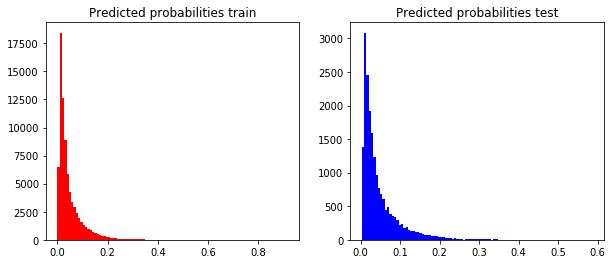

In [136]:
fig, axes = plt.subplots(1,2, figsize=(10,4))
axes[0].hist(pred_prob_tr, bins=100, color='red')
axes[0].title.set_text('Predicted probabilities train')
axes[1].hist(pred_prob_ts, bins=100, color='blue')
axes[1].title.set_text('Predicted probabilities test')

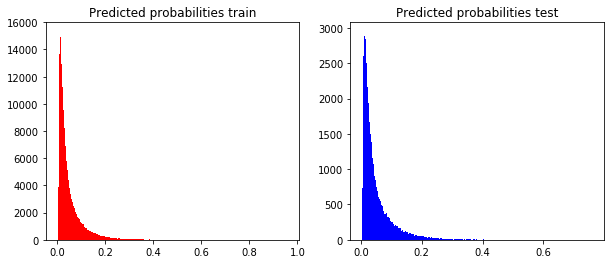

In [138]:
fig, axes = plt.subplots(1,2, figsize=(10,4))
axes[0].hist(pred_prob_tr_full, bins=1000, color='red')
axes[0].title.set_text('Predicted probabilities train');
axes[1].hist(pred_prob_ts_full, bins=1000, color='blue')
axes[1].title.set_text('Predicted probabilities test');

In [141]:
#pred_prob_tr_full[X_tr_full.reset_index()['SCENARIO_NAME_f']=='ATM_3'].shape

In [144]:
X_tr_full.index.levels[2]

Index(['ATM_2', 'ATM_3', 'POS_1', 'POS_2', 'POS_3', 'UVEL_1', 'UVEL_2',
       'UVEL_3', 'UVEL_4', 'UVEL_5', 'UVEL_6'],
      dtype='object', name='SCENARIO_NAME')

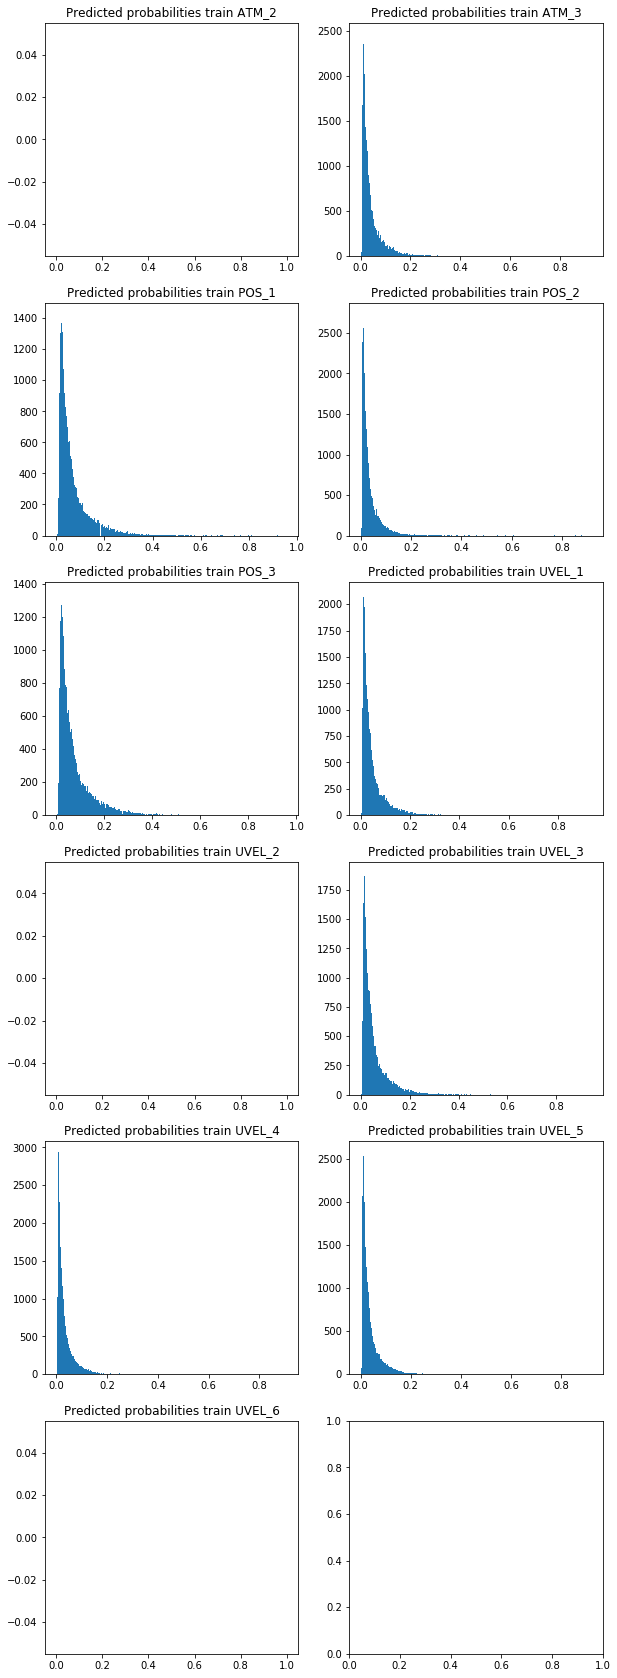

In [143]:
#cm (colormap)
fig, axes = plt.subplots(6, 2, figsize=(10, 30))

for i, sc in enumerate(X_tr_full.index.levels[2]):
    axes[i // 2, i % 2].hist(
        pred_prob_tr_full[X_tr_full.reset_index()['SCENARIO_NAME_f']==sc], 
        bins=1000,
    )
    axes[i // 2, i % 2].title.set_text('Predicted probabilities train' + ' ' + sc);

In [ ]:
# plot train/test prob dist by scenario:

In [333]:
# R matrix simulation:
n_tr = X_tr.shape[0]#40000
n_ts = X_ts.shape[0]
test_size=0.3
#n_ts = int(n*test_size)
#n_tr = n - n_ts 
l = 12
np.random.seed(123)
theta=0.8
R_tr = np.random.binomial(n=1, p=theta, size=n_tr*l).reshape(n_tr,l)
R_ts = np.random.binomial(n=1, p=theta, size=n_ts*l).reshape(n_ts,l)

In [334]:
print(R_tr.shape)
print(R_ts.shape)
print(ids_tr.shape)
print(ids_ts.shape)

(68212, 12)
(29234, 12)
(68212, 3)
(29234, 3)


In [30]:
# PROBLEMS WITH INDEX!!!
#P_tr = pd.concat([ids_tr, pd.Series(pred_prob_tr)], axis=1, ignore_index=False)
#P_ts = pd.concat([ids_ts, pd.Series(pred_prob_ts)], axis=1, ignore_index=False)

In [159]:
P_tr = X_tr_full.copy()
P_tr = P_tr.assign(probs = pred_prob_tr_full)
P_tr = P_tr[['probs']].reset_index()
P_tr.head(24)

,CONTRACT_REF,CLIENT_ID,SCENARIO_NAME,START_DATE,TARGET,SCENARIO_NAME_f,probs
0,273-P-44373697,103676920,POS_3,2016-11-24,0,UVEL_1,0.032707
1,273-P-44373697,103676920,POS_3,2016-11-24,0,UVEL_2,0.027343
2,273-P-44373697,103676920,POS_3,2016-11-24,0,UVEL_3,0.034445
3,273-P-44373697,103676920,POS_3,2016-11-24,0,UVEL_4,0.024198
4,273-P-44373697,103676920,POS_3,2016-11-24,0,UVEL_5,0.028425
5,273-P-44373697,103676920,POS_3,2016-11-24,0,UVEL_6,0.017517
6,273-P-44373697,103676920,POS_3,2016-11-24,0,POS_1,0.037360
7,273-P-44373697,103676920,POS_3,2016-11-24,0,POS_2,0.031026
8,273-P-44373697,103676920,POS_3,2016-11-24,0,POS_3,0.053584
9,273-P-44373697,103676920,POS_3,2016-11-24,0,ATM_1,0.003924


In [162]:
P_tr_long = P_tr.pivot_table(
    values='probs', 
    index=['CONTRACT_REF', 'CLIENT_ID', 'SCENARIO_NAME', 'TARGET', 'START_DATE'], 
    columns=['SCENARIO_NAME_f'],
)

# P_tr_long = pd.DataFrame(
#     data = P_tr_long.values * R_tr,
#     columns = P_tr_long.columns,
#     index = P_tr_long.index
# )

P_tr_long = P_tr_long.assign(top_sc = P_tr_long.idxmax(axis=1))

P_tr_long.head()

,,,,SCENARIO_NAME_f,ATM_1,ATM_2,ATM_3,POS_1,POS_2,POS_3,UVEL_1,UVEL_2,UVEL_3,UVEL_4,UVEL_5,UVEL_6,top_sc
CONTRACT_REF,CLIENT_ID,SCENARIO_NAME,TARGET,START_DATE,,,,,,,,,,,,,
271-P-00002110,103137119,POS_3,0,2017-03-21,0.006139,0.051686,0.037532,0.057362,0.047806,0.081537,0.050348,0.042218,0.052973,0.037428,0.043861,0.027195,POS_3
271-P-00004389,109846924,UVEL_5,0,2017-04-22,0.003461,0.029731,0.021454,0.033081,0.027452,0.047538,0.028945,0.024183,0.030489,0.021393,0.025142,0.015474,POS_3
271-P-00010170,103027265,ATM_2,0,2017-04-08,0.006429,0.054005,0.039242,0.059919,0.049960,0.085075,0.052610,0.044132,0.055346,0.039134,0.045846,0.028449,POS_3
271-P-00010220,105047976,UVEL_2,0,2017-01-23,0.001956,0.016994,0.012218,0.018937,0.015676,0.027388,0.016539,0.013789,0.017433,0.012183,0.014342,0.008790,POS_3
271-P-00016607,109974491,UVEL_5,0,2017-04-22,0.003211,0.027641,0.019933,0.030762,0.025518,0.044253,0.026908,0.022473,0.028347,0.019877,0.023367,0.014371,POS_3


In [168]:
P_tr_long_1 = P_tr_long.drop(['POS_3','top_sc'], axis=1)
P_tr_long_1 = P_tr_long_1.assign(top_sc_2 = P_tr_long_1.idxmax(axis=1))

In [169]:
P_tr_long['top_sc'].value_counts()

POS_3    77956
Name: top_sc, dtype: int64

In [170]:
P_tr_long_1['top_sc_2'].value_counts()

POS_1    77956
Name: top_sc_2, dtype: int64

In [142]:
Xy_train[['CLIENT_ID', 'SCENARIO_NAME', 'TARGET']].groupby(['SCENARIO_NAME'])\
    .agg({
        'TARGET': 'mean',
        'CLIENT_ID': 'count'
    })\
    .sort_values('TARGET', ascending=False)

,TARGET,CLIENT_ID
SCENARIO_NAME,,
POS_1,0.152908,2459
UVEL_3,0.099837,2454
UVEL_1,0.073150,3527
POS_3,0.068110,18984
POS_2,0.050446,10863
UVEL_4,0.040017,26189
UVEL_5,0.039964,5555
ATM_3,0.030435,12847
UVEL_2,0.027259,1981


In [143]:
P_tr_long = P_tr_long.reset_index()

P_tr_long[
    (P_tr_long['SCENARIO_NAME']==P_tr_long['top_sc']) &
    (P_tr_long['TARGET']==1)
].shape[0] / P_tr_long[P_tr_long['TARGET']==1].shape[0]

0.27950643776824036

In [144]:
P_tr_long[
    (P_tr_long['SCENARIO_NAME']==P_tr_long['top_sc']) &
    (P_tr_long['TARGET']==1)
].shape[0]

1042

In [146]:
#P_tr_long[P_tr_long['TARGET']==1]

In [352]:
Xy_train[Xy_train['TARGET']==1].shape

(4642, 153)

In [147]:
#P_tr_long.head(30)

In [171]:
tmp = P_tr_long['POS_3'] - P_tr_long['POS_1']

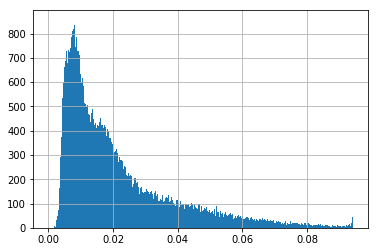

In [172]:
tmp.hist(bins=500);

In [365]:
scen_data

,SCENARIO_NAME,ATM,ANY_POS,BONUS_POS,CATEGORY_POS,MIN_CASHBACK,MAX_CASHBACK,MED_CAHBACK,MIN_SUM_DAY,MIN_SUM_MONTH,key
0,UVEL_1,0,1,0,1,5.00,10.0,6.0,1000,0,1
1,UVEL_2,0,1,0,0,0.00,10.0,5.3,200,0,1
2,UVEL_3,0,1,0,0,10.00,15.0,11.0,1000,0,1
3,UVEL_4,0,1,0,0,0.00,8.3,5.0,1200,0,1
4,UVEL_5,0,1,0,0,3.75,7.5,6.0,200,0,1
5,UVEL_6,0,0,0,1,25.00,25.0,25.0,2000,0,1
6,POS_1,0,0,1,0,5.00,5.0,5.0,0,6000,1
7,POS_2,0,1,0,0,10.00,10.0,10.0,0,6000,1
8,POS_3,0,1,0,0,20.00,20.0,20.0,0,6000,1
9,ATM_1,1,0,0,0,2.00,2.0,2.0,0,6000,1
